In [1]:
using Agents, LinearAlgebra
using InteractiveDynamics
using CairoMakie

mutable struct Bird <: AbstractAgent
    id::Int
    pos::NTuple{2,Float64}
    vel::NTuple{2,Float64}
    speed::Float64
    cohere_factor::Float64
    separation::Float64
    separate_factor::Float64
    match_factor::Float64
    visual_distance::Float64
    infected::Bool
end

┌ Info: Precompiling InteractiveDynamics [ec714cd0-5f51-11eb-0b6e-452e7367ff84]
└ @ Base loading.jl:1342
┌ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
└ @ Base loading.jl:1342


In [2]:
import Pkg; Pkg.add("InteractiveDynamics")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [3]:
function initialize_model(;
    n_birds = 100,
    speed = 1.0,
    cohere_factor = 0.25,
    separation = 4.0,
    separate_factor = 0.25,
    match_factor = 0.01,
    visual_distance = 5.0,
    extent = (100, 100),
    infected  = false,
)
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    model = ABM(Bird, space2d, scheduler = Schedulers.Randomly())
    for _ in 1:n_birds
        vel = Tuple(rand(model.rng, 2) * 2 .- 1)
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
            infected,
        )
    end
    return model
end

initialize_model (generic function with 1 method)

In [24]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
    # Calculate behaviour properties based on neighbors
    
   
    for id in neighbor_ids
        if N == 1
            model[id].infected = true;
        N += 1
        neighbor = model[id].pos
        heading = neighbor .- bird.pos

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading
        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
            model[id].infected = true;
            
            
            
            
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
    end
    N = max(N, 1)
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    move_agent!(bird, model, bird.speed)
end

LoadError: syntax: incomplete: "function" at In[24]:1 requires end

In [16]:
const bird_polygon = Polygon(Point2f[(-0.5, -0.5), (1, 0), (-0.5, 0.5)])
function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) #+ π/2 + π
    scale(rotate2D(bird_polygon, φ), 2)
end

bird_marker (generic function with 1 method)

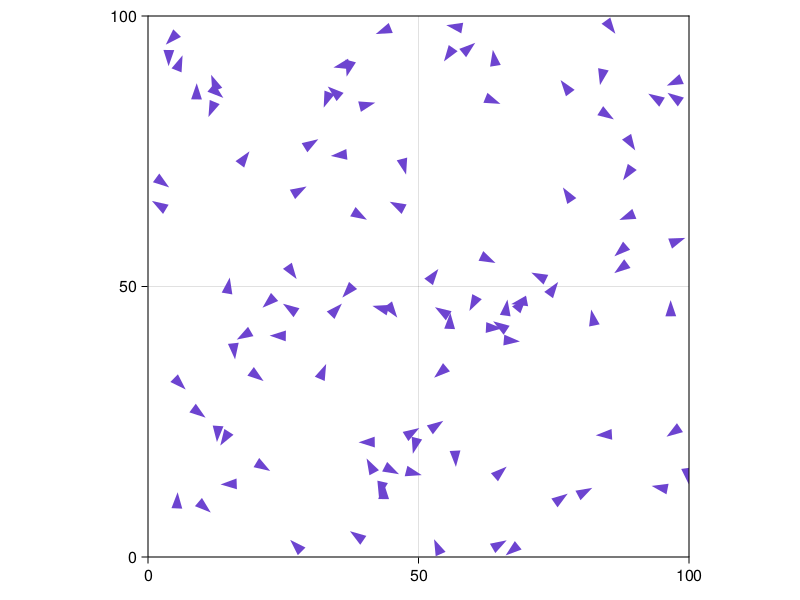

In [19]:
using InteractiveDynamics
using CairoMakie
ac(bird) = bird.infected ? :blue : :black
as(bird) = bird.infected ? 10 : 8


model = initialize_model()
figure, = abmplot(model; am = bird_marker)
figure

In [20]:
abmvideo(
    "flocking.mp4", model, agent_step!;
    am = bird_marker,
    framerate = 10, frames = 200,
    title = "Flocking", ac,as,
)